# Named Entity Recognition using RNN for Nepali Text
                                                                                - Prakash Poudel



In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import preprocess as pp

Using TensorFlow backend.


## Data

Dataset is taken from collection of online newspapers. It is then tagged with proper Entity. 
Let's take a look at data.

In [2]:
addrsrc = os.getcwd()+"/Dataset/Nepali Text Named Entity Dataset.xlsx"

# After Preprocessing all dataset with Tagged Entity are stored into Sentences variable.
NSentences = pp.readfilen(addrsrc,0,1)


#Log Name
lgname = "NER with LSTM with ND working"


senlenth = [len(sen) for sen in NSentences]
MAX_LEN = max(senlenth)
dl = []

# Sentences is being limited to min and max word in a sentence.
for i in range (0,len(NSentences)):
    if len(NSentences[i]) < 5:
                dl.append(i)
    elif len(NSentences[i])>51:
                dl.append(i)

for index in sorted(dl, reverse=True):
    del NSentences[index]
        
import random
print("Random Dataset sample 1 :\n")
print(random.choice(NSentences))
print("\nRandom Dataset sample 2 :\n")
print(random.choice(NSentences))

Random Dataset sample 1 :

[['हामी', 'O'], ['छ', 'O'], ['जना', 'O'], ['दर्ुइवटा', 'O'], ['गाडीमा', 'B-PDT'], ['थियौ', 'O']]

Random Dataset sample 2 :

[['अझ', 'O'], ['केही', 'O'], ['अर्थशास्त्रीहरू', 'O'], ['त', 'O'], ['बहुराष्ट्रिय', 'B-ORG'], ['निगमका', 'I-ORG'], ['कार्यकारी', 'O'], ['अध्यक्षहरू', 'O'], ['पदाधिकारीहरूको', 'O'], ['सामूहिक', 'O'], ['गल्तीको', 'O'], ['उपज', 'O'], ['बताइरहेका', 'O'], ['छन्', 'O']]


In [3]:

# All for Log Purpose
allWords = []
allTags = []
dataset_det = ""


for i in  NSentences:
    for wod in i:
        allWords.append(wod[0])
        allTags.append(wod[1])


alldTags = list(set(allTags))
alldWords = list(set(allWords))


n_allTags = len(allTags)
n_allWords = len(allWords)

n_Ntags = len(alldTags)
n_Nwords = len(alldWords)

# Log purpose
dataset_det = (dataset_det + 
    "All tag size \t:"+ str(n_allTags) +
    "\nAll word size \t:"+ str(n_allWords)+
    "\n\nTotal Distinct words in the dataset \t: "+ str(n_Nwords) +
    "\nTotal number of Labels \t\t\t: "+ str(n_Ntags) +
    "\nTotal number of Sentences \t\t: "+ str(len(NSentences)) +
    "\n\nTags:\n"+ str(alldTags))
    



In [4]:
# Callback Time while training 
from time import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)
        
time_callback = TimeHistory()

In [5]:
# Defined to append all the figures into one List - For log purpose
allfig = []

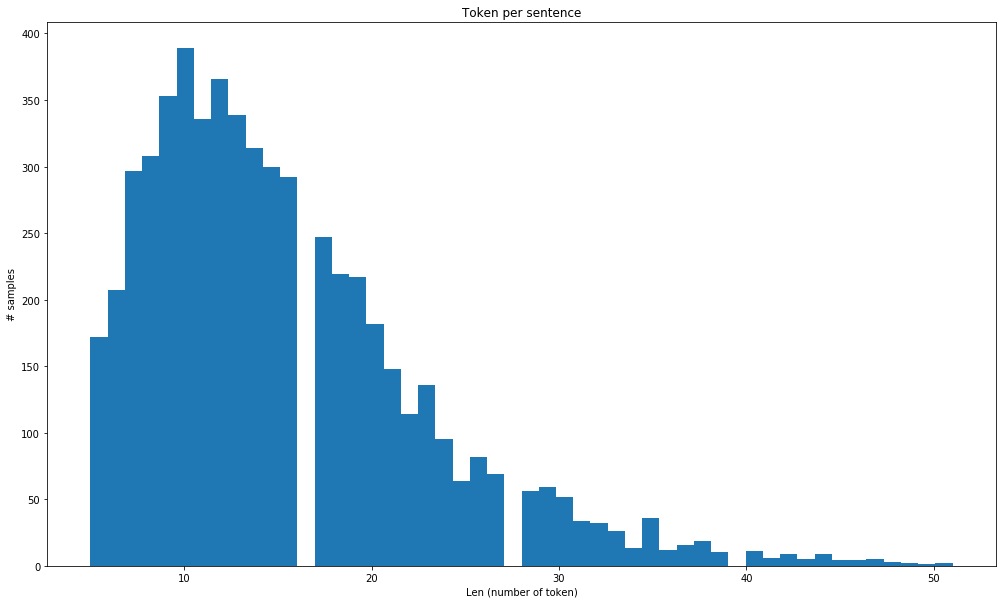

In [6]:

#sentences=NSentences
# Plot sentence by length
plt.figure(figsize=(17,10))
plt.hist([len(s) for s in NSentences], bins=50)
title = 'Token per sentence'
plt.title(title)
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.rcParams.update({'font.size': 18})
allfig.append([plt.gcf(),title])
plt.show()


## Data Preprocessing

Before feeding the data into the model, we have to preprocess the text.

- We will use the `word2idx` dictionary to convert each word to a corresponding integer ID and the `tag2idx` to do the same for the labels. Representing words as integers saves a lot of memory!
- In order to feed the text into our LSTM, all texts should be the same length. We ensure this using the `sequence.pad_sequences()` method and `MAX_LEN` variable. All texts longer than `MAX_LEN` are truncated and shorter texts are padded to get them to the same length.

The *Tokens per sentence* plot (see above) is useful for setting the `MAX_LEN` training hyperparameter.

In [7]:
def pltTagdist (height,bars,title):
    plt.figure(figsize=(15,4))
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height, color=(0.2, 0.4, 0.6, 0.6))

    # use the plt.xticks function to custom labels
    plt.xticks(y_pos, bars, color='Black', rotation=45, fontweight='bold', fontsize='12', horizontalalignment='right')
    plt.title(title)
    plt.xlabel('Tagset')
    plt.ylabel('Tokens')
    plt.tick_params(labelbottom='on')
    return plt , title


In [8]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK

tags = []
words = []
words = list(set(allWords))
tags = list(set(allTags))

words.insert(0, "PAD")
words.insert(1, "UNK")

word2idx = {w: i for i, w in enumerate(words)}

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tags.insert(0, "PAD")
tag2idx = {t: i for i, t in enumerate(tags)}


# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

# For checking the index of a word in dataset
print("The word सरकारलाई is identified by the index: {}".format(word2idx["सरकारलाई"]))
print("The labels B-PER(which defines Person Name) is identified by the index: {}".format(tag2idx["B-PER"]))


from keras.preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[float(word2idx[w[0]]) for w in s] for s in NSentences]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in NSentences]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])


The word सरकारलाई is identified by the index: 12597
The labels B-PER(which defines Person Name) is identified by the index: 18


In [9]:
from keras.utils import to_categorical

# One-Hot encoding

y = [to_categorical(i, num_classes=n_Ntags+1) for i in y]  


In [10]:
# Converting List into Numpy Array Format
X = np.array(X)
y = np.array(y)

In [11]:
# Opposite of One Hot Encoding.
def revrcatgry(y): # It takes 3D matrix 
    y = list(y)
    z = [np.argmax(i, -1) for i in y]
    return np.array(z)


In [12]:
# Splitting Data into Train and Test Data
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)


In [13]:
print(str(X_tr.shape)+" - Shape of X_train")
print(str(X_te.shape)+" - Shape of X_test")
print(str(y_tr.shape)+" - Shape of y_train")
print(str(y_te.shape)+" - Shape of y_test\n")

print('Raw Sample: ', ' '.join([w[0] for w in NSentences[2]]))
print('Raw Label: ', ' '.join([w[1] for w in NSentences[2]]))


(5104, 104) - Shape of X_train
(568, 104) - Shape of X_test
(5104, 104, 19) - Shape of y_train
(568, 104, 19) - Shape of y_test

Raw Sample:  नेतृ कोइरालाले विपक्षी दल र सत्तारुढ दल दुबै सडकमा आउँदा मुठभेडको स्थिति आउने भएकाले सहमतिको विकल्प नरहेको वताउनुभयो
Raw Label:  O I-PER O O O O O O B-FAC O B-EVT O O O O O O O


In [14]:

yy = [[ w[1] for w in s] for s in NSentences]

# Allocating all the tag into one single List

alltag=[]
for sentence in yy:
    for tag in sentence:
        alltag.append(tag)



# for Arranging the Distinct Tag using Value ascending order
disttag = []    
def get_key(val): 
    for key, value in tag2idx.items(): 
         if val == value: 
            return key 

for i in range(0,len(tag2idx)-1):
    disttag.append(get_key(i)) 

tagd=[]
for i in disttag:
    ab = alltag.count(i)
    tagd.append([i,ab])

In [15]:

# This part is used for Log info
tagdtxt=""
for i in tagd:
    tagdtxt = tagdtxt+i[0]+" "+str(i[1])+"\n"
  

<Figure size 1224x720 with 0 Axes>

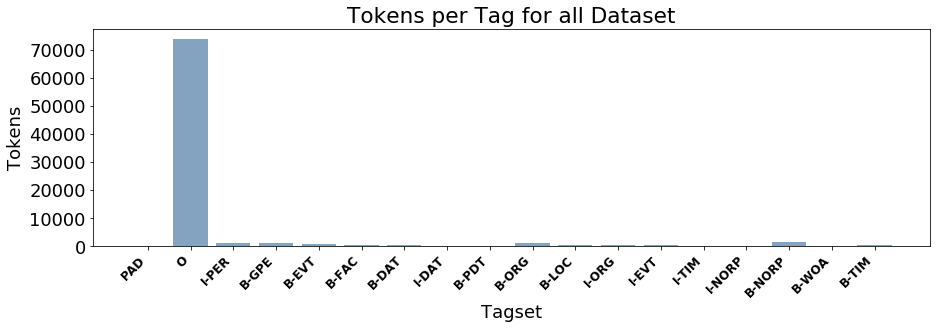

In [16]:
# Tag Distribution in Dataset 
height = [tag[1] for tag in tagd]
bars = [tag[0] for tag in tagd]

title = 'Tokens per Tag for all Dataset'
plt.figure(figsize=(17,10))
plt,title = pltTagdist(height,bars,title)
allfig.append([plt.gcf(),title])
plt.rcParams.update({'font.size': 12})
plt.show()


# Function Defination

In [17]:
#  Graph of Time Complexity
def timcomp(epoch,tim,title):
    plt.rcParams.update({'font.size': 20})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.figure(figsize=(17,10))
    plt.plot(epoch,tim,linewidth=3.5)
    title = title
    plt.title(title)
    plt.ylabel('Time (sec)')
    plt.xlabel('Epoch')
    
    return plt,title


In [18]:
# Graph Of Accuracy 

def acplot(acc,val_acc):    
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(17,10))
    plt.plot(acc,linewidth=3.5)
    plt.plot(val_acc,linewidth=3.5)
    title = 'Model Accuracy'
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    return plt, title

In [19]:
# Graph of Loss
def lsplot(loss,val_loss):
    plt.rcParams.update({'font.size': 20})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.figure(figsize=(17,10))
    plt.plot(loss,linewidth=3.5)
    plt.plot(val_loss,linewidth=3.5)
    title = 'Model Loss'
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    return plt,title

In [20]:
# Plot Confusing Matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.rcParams.update({'font.weight': 'normal'})
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(22,12))
    #ax.figure(figsize=(30,30))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor",weight='bold')
    plt.setp(ax.get_yticklabels(),weight='bold')
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return plt,title

## Model
Here LSTM Recurrent Neural Network is used for constructing a model. It is the trained by the labeled tags from the Nepali corpus.

In [21]:
from keras.models import Model, InputLayer
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [22]:
#Hyperparameter initialization

EPOCHS = 2
DROPOUT_RECURRENT = 0.1
EMBEDDING = 102
LSTM_Units = 15
LEARNING_RATE = 0.002
BATCH_SIZE = 100
d1 = 76
opti = Adam(LEARNING_RATE)
Note = "Epoch " + str(EPOCHS)

In [23]:
# Dividing the Data set into Train and test dataset with required ratio.
ratio = 0.71
up = int(X.shape[0]*ratio)

X_tr = X[0:up]
X_te = X[up:X.shape[0]]

y_tr = y[0:up]
y_te = y[up:X.shape[0]]

In [24]:
  
Dense_layer1 = d1
DROPOUT1 = 0.5

# Model 1 definition

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LEN, )))
model.add(Embedding(input_dim=n_Nwords+2, output_dim=EMBEDDING,
                  input_length=MAX_LEN, mask_zero=True))


model.add(LSTM(units=LSTM_Units, return_sequences=True,recurrent_dropout=DROPOUT_RECURRENT,activation='relu'))
model.add(BatchNormalization())


#model.add(Bidirectional(LSTM(units=LSTM_Units, return_sequences=True,recurrent_dropout=DROPOUT_RECURRENT,activation='relu')))
#model.add(BatchNormalization())

model.add(Dense(Dense_layer1,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT1))

model.add(TimeDistributed(Dense(n_Ntags+1)))
model.add(Activation('softmax'))

model.compile(optimizer=opti, loss='categorical_crossentropy', metrics=['accuracy'])

# for finding the optimzer used.
#opt = str(type(model.optimizer)).split('.')
#optm = opt[-1].replace("'>","")

## Print The Summary of the Model
model.summary()

NameError: name 'math_ops' is not defined

In [ ]:
history = model.fit(X_tr, y_tr, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(X_te,y_te),
                    verbose=1,callbacks=[time_callback])

#Hyperparameter initialization

EPOCHS = 20
DROPOUT_RECURRENT = 0.1
EMBEDDING = 102
LSTM_Units = 153
LEARNING_RATE = 0.002
BATCH_SIZE = 32
d1 = 76
opti = Adam(LEARNING_RATE)
Note = "Epoch " + str(EPOCHS) + " "+arc

In [ ]:
    
# For Calculating Average Loss and Minimum Loss
avlos = round(np.average(history.history['val_loss']),2)
minlos = round(np.min(history.history['val_loss']),2)

# For Calculating Accuracy and Maximum Accuracy 
accuracy = round(np.mean(history.history['acc']),4)
max_accuracy = round(np.max(history.history['acc']),4)

#For Calculating Validating Accuracy and Max Validating Accuracy
val_accuracy = round(np.mean(history.history['val_acc']),4)
max_val_accuracy = round(np.max(history.history['val_acc']),4)


# for Time in each Epoch
tim = [int(tm) for tm in time_callback.times]
epoch = [ab for ab in range(0,EPOCHS)]

# for cumulative Time 
timnp = np.array(tim)
totaltime = np.sum(tim)
timnp = np.cumsum(timnp)
timsm = list(timnp)

In [ ]:
# adding Model Time complexity graph into list
title = 'Model Timecomplexity'
plt,title = timcomp(epoch,tim,title)
allfig.append([plt.gcf(),title])

# adding Model Time complexity Cumulative graph into list
title = 'Model Timecomplexity cumulative'
plt,title = timcomp(epoch,timsm,title)
allfig.append([plt.gcf(),title])

# Call acplot and  adding Accuracy graph into list
plt,title = acplot(history.history['acc'],history.history['val_acc'])
allfig.append([plt.gcf(),title])

# Call lsplot and adding Loss graph into list
plt,title = lsplot(history.history['loss'],history.history['val_loss'])
allfig.append([plt.gcf(),title])

In [ ]:
# Predicting for Test data 
pred_cat = model.predict(X_te)
preddd = pred_cat
pred_cat.shape
predall = np.argmax(pred_cat, axis=-1)

In [ ]:
'''lst = []
[[lst.append([])] for i in range (0, n_Ntags+1)]
for j in range(0,X_te.shape[0]):
    alxte = X_te[j]
    alpred_cat = pred_cat[j]
    alyte = altrnopt[j]

    pred = np.argmax(alpred_cat, axis=-1)
    pred = list(pred)

    acc = list(alyte)


    #print(lst)
    for i in range(0,len(pred)):
        if acc[i] == 0:
                   pred[i]=0
        if acc[i] != pred[i]:
            label = acc[i]
            word = alxte[i]

            lst[label].append("\t"+idx2word[word]+"\t\t\t ->  "+str(idx2tag[pred[i]]))


'''

In [ ]:
# For Multi Level Classification Report
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score


indx = np.argmin(y_te_true, axis=1)
for i in range (0,len(predall)):
    predall[i][indx[i]:len(predall[i])]=0


# Flat classification Report
pred_tag = [[idx2tag[i] for i in row] for row in predall]

y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

clas_report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(clas_report)

f1= round(f1_score(y_te_true.reshape(-1), predall.reshape(-1), average='macro'),2)

allf1 = f1_score(y_te_true.reshape(-1), predall.reshape(-1), average=None)

# For finding the Deviation of the F1 score of all tags from highest F1 score 100 
from math import sqrt
sm = 0
for a in allf1:
    num = (a*100-100)*(a*100-100)
    sm = sm + num
den = allf1.shape[0]
cudev = round(sqrt(sm/den),2)
print(cudev) # deviation score of F1 score from Highest score

In [ ]:
# Confusion Matrix processing and Plot
pred_tag_num = [[tag2idx.get(i) for i in s] for s in pred_tag]
y_te_true_tag_num = [[tag2idx.get(i) for i in s] for s in y_te_true_tag]

pred_tag_numpy = np.array(pred_tag_num)
y_te_true_tag_numpy = np.array(y_te_true_tag_num)
y_te_true_tag_numpy.shape
sing_tru_tag = y_te_true_tag_numpy.reshape(-1)
sing_pred_tag = pred_tag_numpy.reshape(-1)
print(sing_pred_tag.shape)
sing_tru_tag.shape

class_name = [idx2tag[i] for i in range (0,len(tag2idx))]
class_name_nmpy = np.array(class_name)

# Plotting Confussion Matrix
plt,title = plot_confusion_matrix(sing_tru_tag[1:],sing_pred_tag[1:], classes=class_name_nmpy[:],normalize=True,
                      title='Normalized Confusion Matrix')
# Saving CM into list
allfig.append([plt.gcf(),title])

In [ ]:
# Reporting Work and status


import pickle
import logeditor as lg
import os
pth = lg.pathcreator(lgname)

# Create Hyperparameter.txt in ML Log Folder and Update following details

file = lg.filecreator("Hyperparameter",pth)
lg.write2file('Hyper Parameter Details',file)
lg.write2file('Learning Rate '+str(LEARNING_RATE),file)
lg.write2file('Epoch '+str(EPOCHS) ,file)
lg.write2file('Batch Size '+str(BATCH_SIZE),file)
lg.write2file('Embedding '+str(EMBEDDING),file)
lg.write2file('LSTM Units '+str(LSTM_Units),file)
lg.write2file('Dataset Address '+str(addrsrc),file)
lg.write2file('LSTM Recurrent Dropout '+str(DROPOUT_RECURRENT),file)

In [ ]:
# create Results.txt file in ML log folder and update following details

file = lg.filecreator("Results",pth)
lg.write2file('Results details',file)
lg.write2file('Mean Accuracy '+str(accuracy),file)
lg.write2file('Mean Validation Accuracy '+str(val_accuracy),file)
lg.write2file('Total Time taken in Seconds - '+str(totaltime),file)


lg.filecreatorw('Tag frequency Details',tagdtxt,pth)
lg.filecreatorw('Classification Report',clas_report,pth)
lg.filecreatorw('Dataset Details',dataset_det,pth)

with open(pth + '/Model Configuration.txt','w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

In [ ]:
#for saving all the fig into file from the prepared list allfig
for index,lst in enumerate(allfig):
    figg = lst[0]
    nm = lst[1]
    figg.tight_layout()
    figg.savefig(pth+"/"+nm+str(index)+".png")

In [ ]:
# For Saving the trained model
with open(pth+'/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Saving Vocab
with open(pth+'/tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Saving Model Weight
model.save_weights(pth+'/NER_LSTM_weights.h5')
model.save(pth+'/NER_LSTM_MODEL.h5')
print("Completed Sucessfully...!!! ")